In [9]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical

# Function to load a single image
def load_image(filename, folder):
    img = Image.open(os.path.join(folder, filename))
    if img is not None:
        return np.array(img)
    return None

# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    for filename in filenames:
        img = load_image(filename, folder)
        if img is not None:
            images.append(img)
    return images, filenames

# Function to create dataset from folders without a subset size
def create_full_dataset(base_path):
    real_path = os.path.join(base_path, 'REAL')
    fake_path = os.path.join(base_path, 'FAKE')
    
    real_images, real_filenames = load_images_from_folder(real_path)
    fake_images, fake_filenames = load_images_from_folder(fake_path)
    
    # Ensure equal representation of Real and Fake images
    min_size = min(len(real_images), len(fake_images))
    
    real_images = real_images[:min_size]
    fake_images = fake_images[:min_size]
    
    X = np.array(real_images + fake_images)
    y = np.array([1] * len(real_images) + [0] * len(fake_images))
    
    # Shuffle the dataset
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    # Normalize the images
    X = X / 255.0
    
    return X, y

# Paths to dataset folders
train_path = r"C:\Users\Sara1410\Downloads\archive (2)\train"
test_path = r"C:\Users\Sara1410\Downloads\archive (2)\test"

# Create training and testing datasets without subset limitation
X_train, y_train = create_full_dataset(train_path)
X_test, y_test = create_full_dataset(test_path)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

# Ensure that the shapes are correct
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (100000, 32, 32, 3)
y_train shape: (100000, 2)
X_test shape: (20000, 32, 32, 3)
y_test shape: (20000, 2)


start 9:01
END 9:15

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define the CNN model from scratch
#Defines a Sequential model that stacks layers one after the other.
#model architecture is linear, i.e., each layer has one input tensor and one output tensor.
model = Sequential([
    #Specifies the input shape based on the training data
    Input(shape=X_train.shape[1:]),
    # convolutional layer with 32 filters, 3x3 kernel size, 
    #ReLU activation function,for non-linearity to the model, which allows the network to learn complex patterns and representations
    #and 'same' padding (so the output size remains the same).
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    #Adds a max-pooling layer that reduces the spatial dimensions by half (2x2 pool size).
    MaxPooling2D((2, 2)),
    #The same pattern is repeated for layers with 64, 128, and 256 filters to extract more complex features at each level.
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    #Flatten(): Converts the multi-dimensional feature maps into a 1D vector
    Flatten(),
    #Adds a fully connected layer with 512 neurons and ReLU activation.
    Dense(512, activation='relu'),
    #Randomly sets 50% of the layer’s units to 0 during training to prevent overfitting.
    Dropout(0.5),
    #Output layer with 2 units (for binary classification) and softmax activation to get probabilities.
    Dense(2, activation='softmax')  # Number of classes
])

# Compile the model without a learning rate scheduler
#Prepares the model for training
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Summary of the model
model.summary()

# Data Augmentation,(increases the size and diversity of the training dataset by applying random transformations to the input images)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    #fill in new pixels that are introduced when shifting, rotating, or shearing the image.
    fill_mode='nearest'
)

datagen.fit(X_train)

# Custom training loop
epochs = 100  # Increase epochs
batch_size = 32
#if the validation loss doesn't improve for 25 consecutive epochs, the training will stop early.
patience = 25
#By setting it to infinity initially, the first validation loss 
#the model encounters will automatically be smaller and will update
best_val_loss = np.inf
#Once wait reaches the patience limit (i.e., 25), early stopping is triggered
wait = 0

#creates a data generator that will produce batches of training data (images and labels) for training.
train_data = datagen.flow(X_train, y_train, batch_size=batch_size)
#This calculates how many batches (or "steps") are needed to complete one epoch
steps_per_epoch = len(X_train) // batch_size

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Training loop:this loop handles training the model one batch at a time, 
    #helping the model improve with each step by adjusting its weights to reduce the error (loss).
    
    for step in range(steps_per_epoch):  # Loop through each batch in the epoch
        X_batch, y_batch = next(train_data) # Get the next batch of images and labels from the data generator (32 images per batch)
        with tf.GradientTape() as tape: # Start recording operations to compute gradients
            predictions = model(X_batch, training=True) # Make predictions for the current batch of images
            loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions) # Calculate the loss between true labels and predicted labels
        
        gradients = tape.gradient(loss, model.trainable_variables) # Calculate the gradients of the loss with respect to the model's weights
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # Use the optimizer (Adam) to adjust the weights based on the gradients
    
    # Validation
    val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}, Validation AUC: {val_auc}")
    
    # Early stopping and checkpoint logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        model.save('best_model.h5')
        print("Checkpoint saved")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

# Save the trained model
model.save('cnn_model_from_scratch.h5')

# Evaluate the model
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Test Precision: {precision}, Test Recall: {recall}, Test AUC: {auc}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

C:\Users\Sara1410\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Validation Loss: 0.5139058828353882, Validation Accuracy: 0.7640500068664551, Validation Precision: 0.7640500068664551, Validation Recall: 0.7640500068664551, Validation AUC: 0.8624417781829834
Epoch 3/100
Validation Loss: 0.36707568168640137, Validation Accuracy: 0.8200500011444092, Validation Precision: 0.8200500011444092, Validation Recall: 0.8200500011444092, Validation AUC: 0.9157953858375549
Checkpoint saved
Epoch 4/100
Validation Loss: 0.2862297296524048, Validation Accuracy: 0.8766499757766724, Validation Precision: 0.8766499757766724, Validation Recall: 0.8766499757766724, Validation AUC: 0.9503906965255737
Checkpoint saved
Epoch 5/100
Validation Loss: 0.44772952795028687, Validation Accuracy: 0.8210499882698059, Validation Precision: 0.8210499882698059, Validation Recall: 0.8210499882698059, Validation AUC: 0.9070259928703308
Epoch 6/100
Validation Loss: 0.278831422328949, Validation Accuracy: 0.8868499994277954, Validation Precision: 0.8868499994277954, Validation Recall: 0.

Validation Loss: 0.19897443056106567, Validation Accuracy: 0.9230499863624573, Validation Precision: 0.9230499863624573, Validation Recall: 0.9230499863624573, Validation AUC: 0.9762865304946899
Epoch 42/100
Validation Loss: 0.36079758405685425, Validation Accuracy: 0.8575999736785889, Validation Precision: 0.8575999736785889, Validation Recall: 0.8575999736785889, Validation AUC: 0.9385835528373718
Epoch 43/100
Validation Loss: 0.3224141597747803, Validation Accuracy: 0.8857499957084656, Validation Precision: 0.8857499957084656, Validation Recall: 0.8857499957084656, Validation AUC: 0.9483342170715332
Epoch 44/100
Validation Loss: 0.21546252071857452, Validation Accuracy: 0.9189500212669373, Validation Precision: 0.9189500212669373, Validation Recall: 0.9189500212669373, Validation AUC: 0.9736210703849792
Epoch 45/100
Validation Loss: 0.25666072964668274, Validation Accuracy: 0.9039499759674072, Validation Precision: 0.9039499759674072, Validation Recall: 0.9039499759674072, Validatio

Validation Loss: 0.244050994515419, Validation Accuracy: 0.9017999768257141, Validation Precision: 0.9017999768257141, Validation Recall: 0.9017999768257141, Validation AUC: 0.9683535099029541
Epoch 82/100
Validation Loss: 0.2335001528263092, Validation Accuracy: 0.9125000238418579, Validation Precision: 0.9125000238418579, Validation Recall: 0.9125000238418579, Validation AUC: 0.9702873826026917
Epoch 83/100
Validation Loss: 0.1763397753238678, Validation Accuracy: 0.9242500066757202, Validation Precision: 0.9242500066757202, Validation Recall: 0.9242500066757202, Validation AUC: 0.980925440788269
Checkpoint saved
Epoch 84/100
Validation Loss: 0.21604801714420319, Validation Accuracy: 0.9136999845504761, Validation Precision: 0.9136999845504761, Validation Recall: 0.9136999845504761, Validation AUC: 0.9736545085906982
Epoch 85/100
Validation Loss: 0.21120402216911316, Validation Accuracy: 0.9176999926567078, Validation Precision: 0.9176999926567078, Validation Recall: 0.91769999265670

In [11]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best_model.h5')

# Evaluate the best model on the validation data
best_val_loss, best_val_accuracy, best_val_precision, best_val_recall, best_val_auc = best_model.evaluate(X_test, y_test)

print(f"Best Model Validation Loss: {best_val_loss}")
print(f"Best Model Validation Accuracy: {best_val_accuracy}")
print(f"Best Model Validation Precision: {best_val_precision}")
print(f"Best Model Validation Recall: {best_val_recall}")
print(f"Best Model Validation AUC: {best_val_auc}")

625/625 [==============================] - 6s 10ms/step - loss: 0.1763 - accuracy: 0.9243 - precision: 0.9243 - recall: 0.9243 - auc: 0.9809
Best Model Validation Loss: 0.1763397753238678
Best Model Validation Accuracy: 0.9242500066757202
Best Model Validation Precision: 0.9242500066757202
Best Model Validation Recall: 0.9242500066757202
Best Model Validation AUC: 0.980925440788269


start 9:19  

625/625 [==============================] - 6s 9ms/step


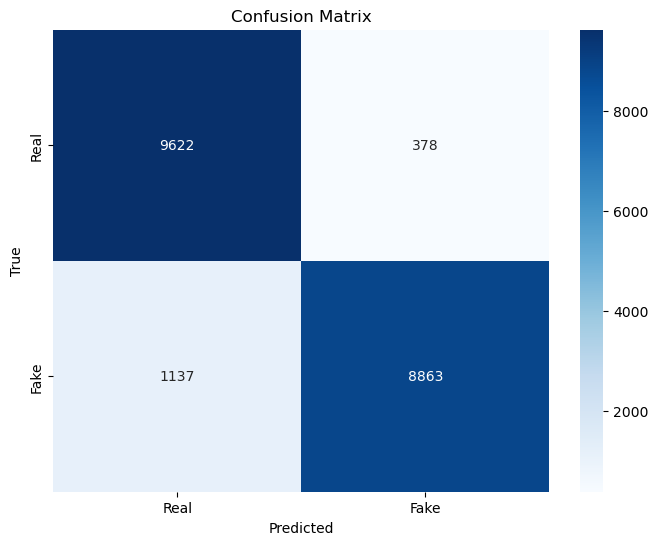

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the test set
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [14]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

        Real       0.89      0.96      0.93     10000
        Fake       0.96      0.89      0.92     10000

    accuracy                           0.92     20000
   macro avg       0.93      0.92      0.92     20000
weighted avg       0.93      0.92      0.92     20000



1/1 [==============================] - 0s 112ms/step


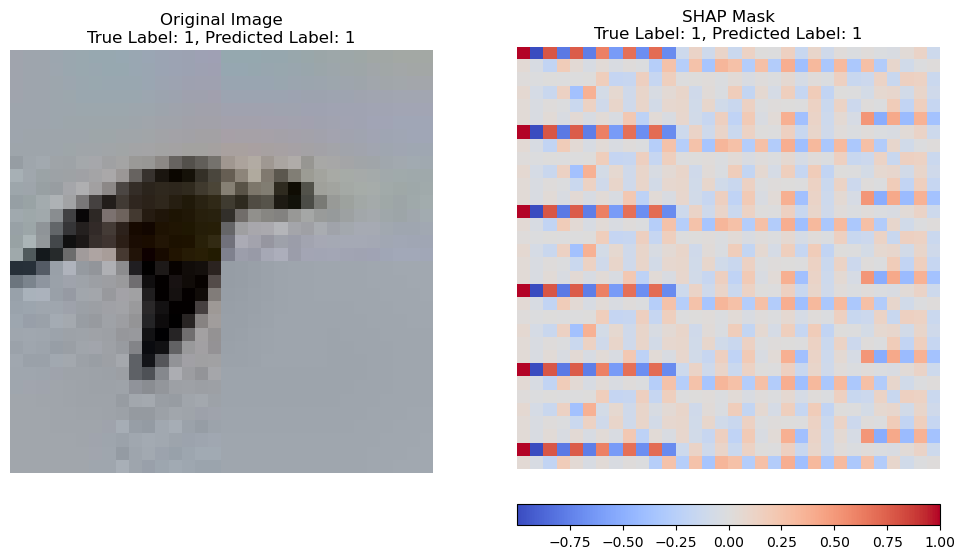

1/1 [==============================] - 0s 26ms/step


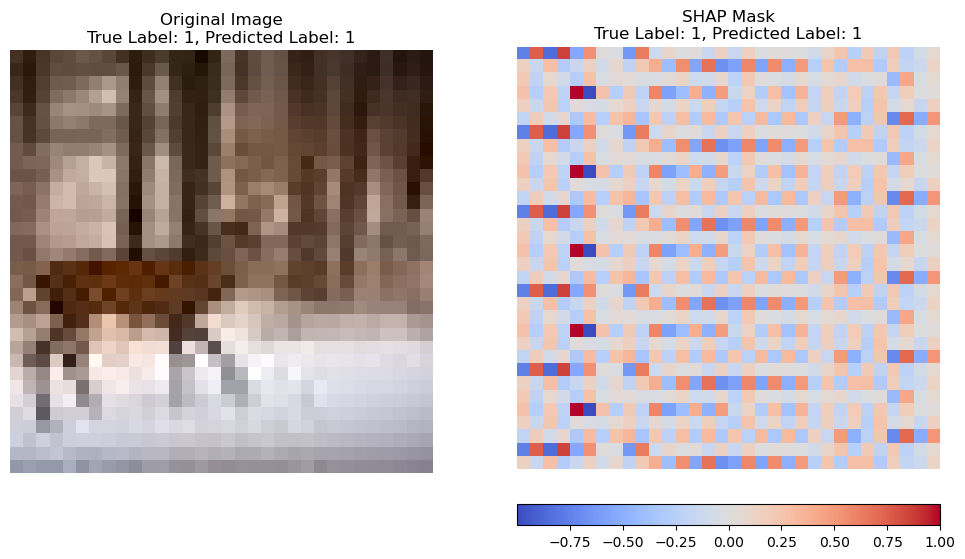

1/1 [==============================] - 0s 30ms/step


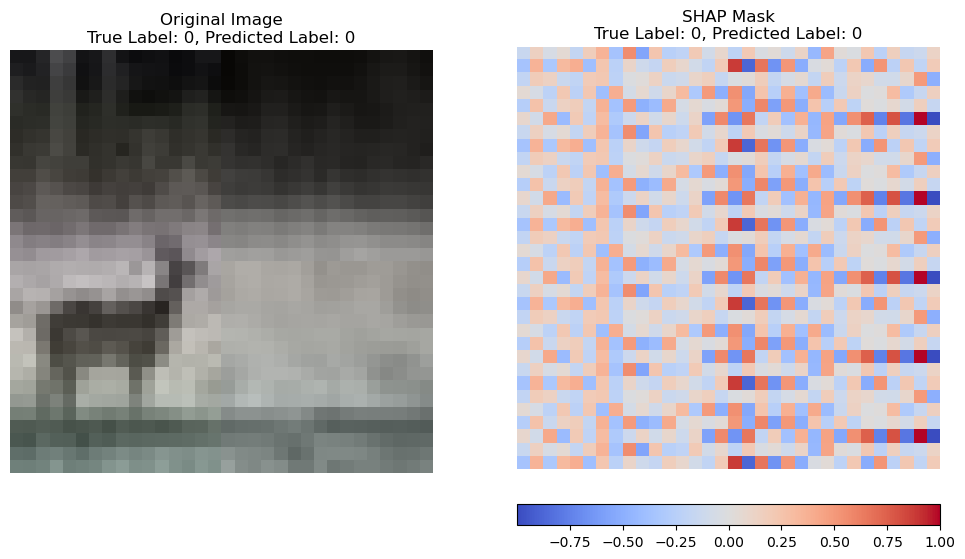

1/1 [==============================] - 0s 24ms/step


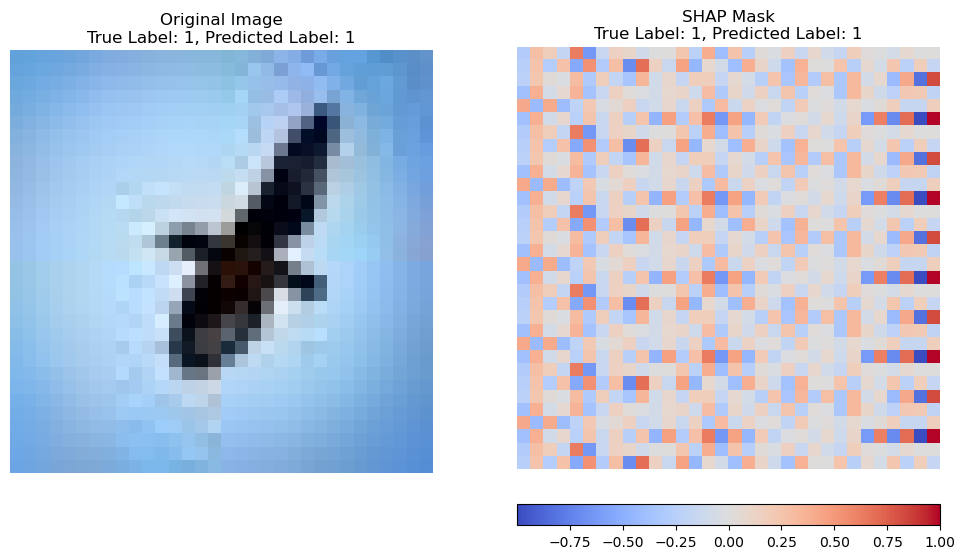

1/1 [==============================] - 0s 36ms/step


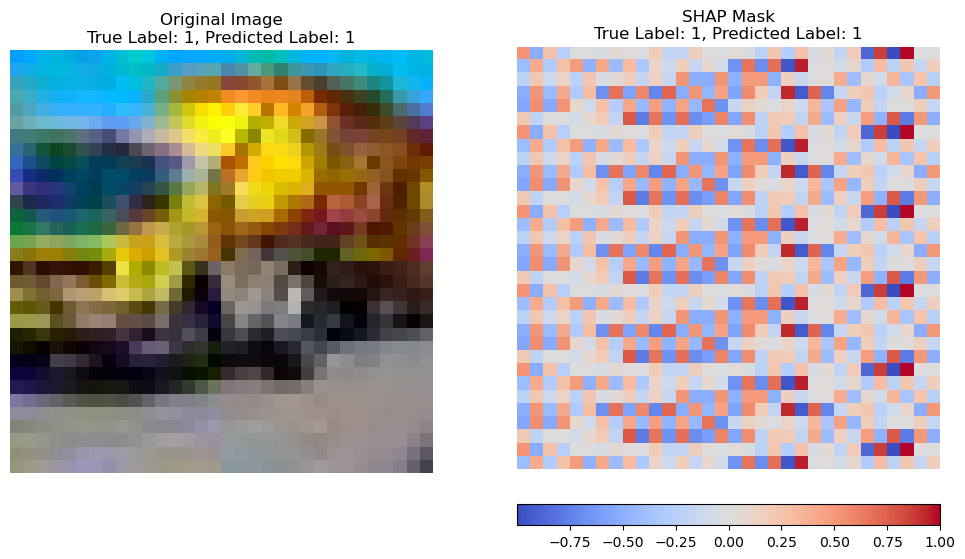

1/1 [==============================] - 0s 40ms/step


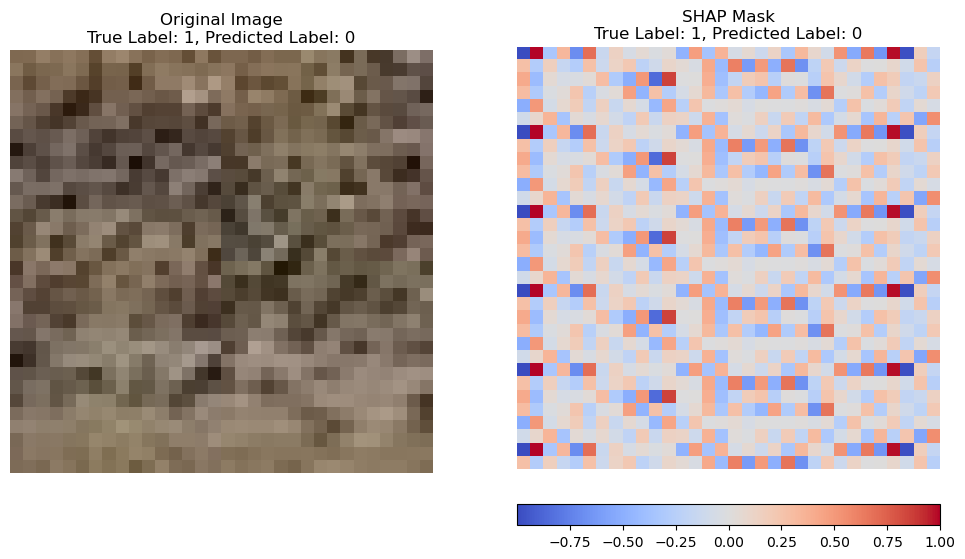

1/1 [==============================] - 0s 23ms/step


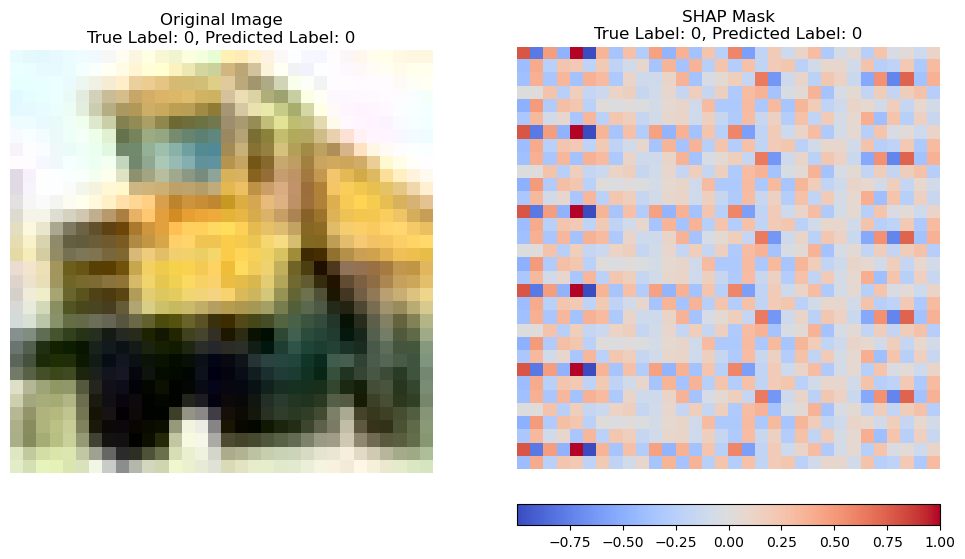

1/1 [==============================] - 0s 27ms/step


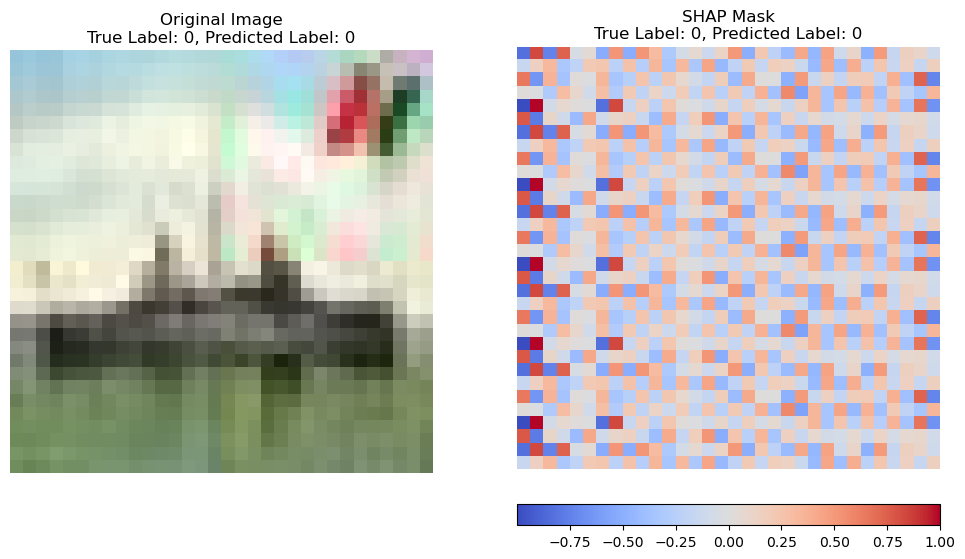

1/1 [==============================] - 0s 24ms/step


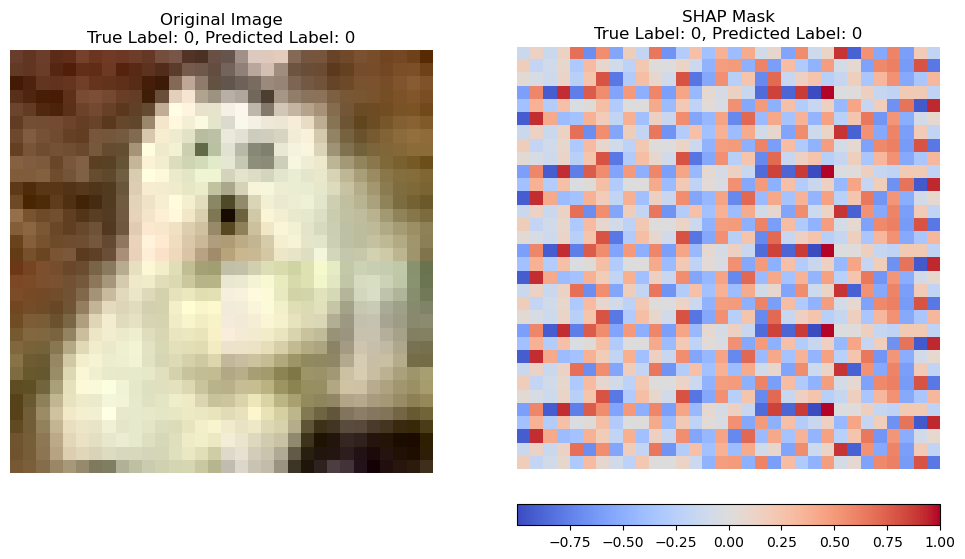

1/1 [==============================] - 0s 27ms/step


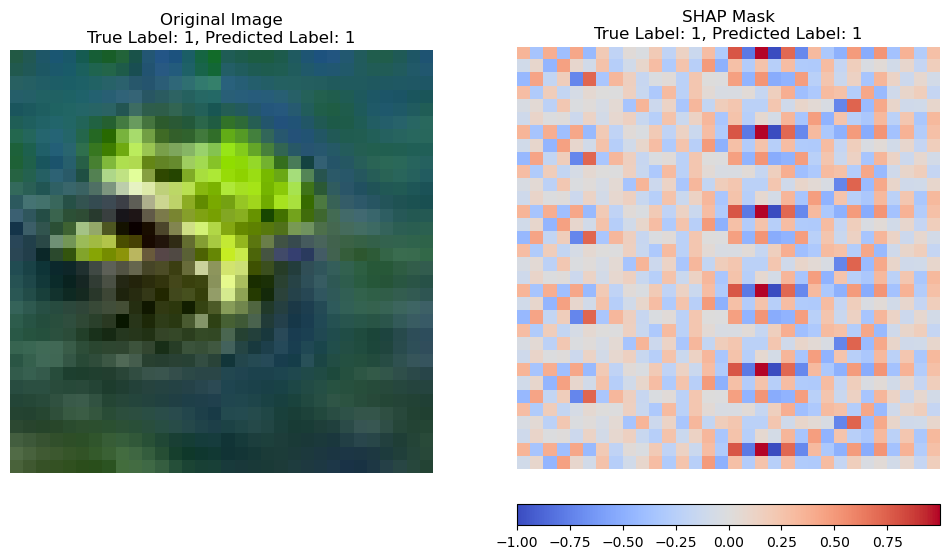

1/1 [==============================] - 0s 20ms/step


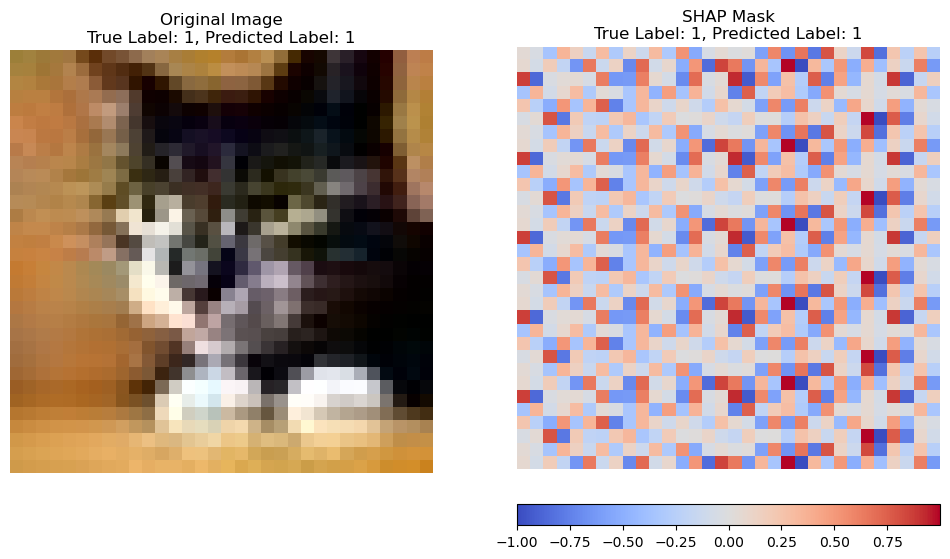

1/1 [==============================] - 0s 28ms/step


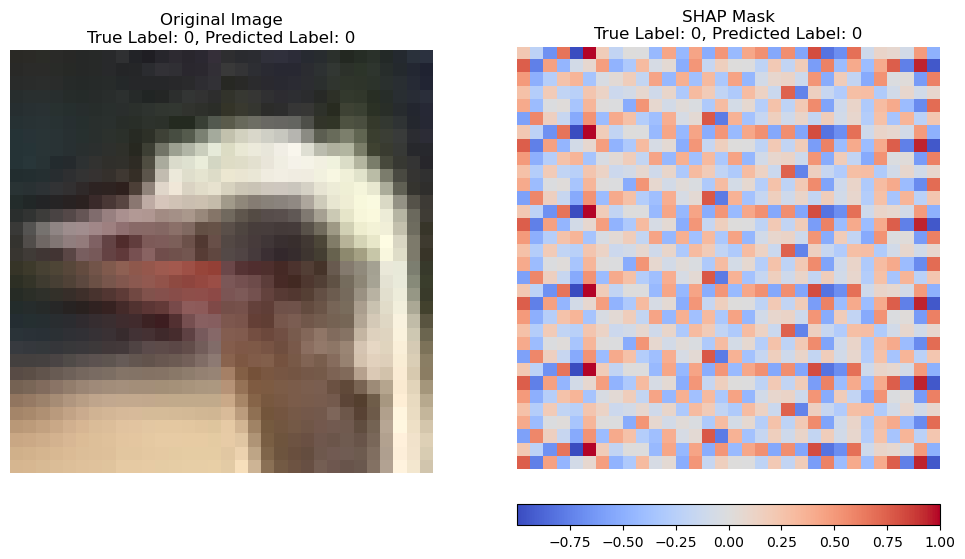

1/1 [==============================] - 0s 25ms/step


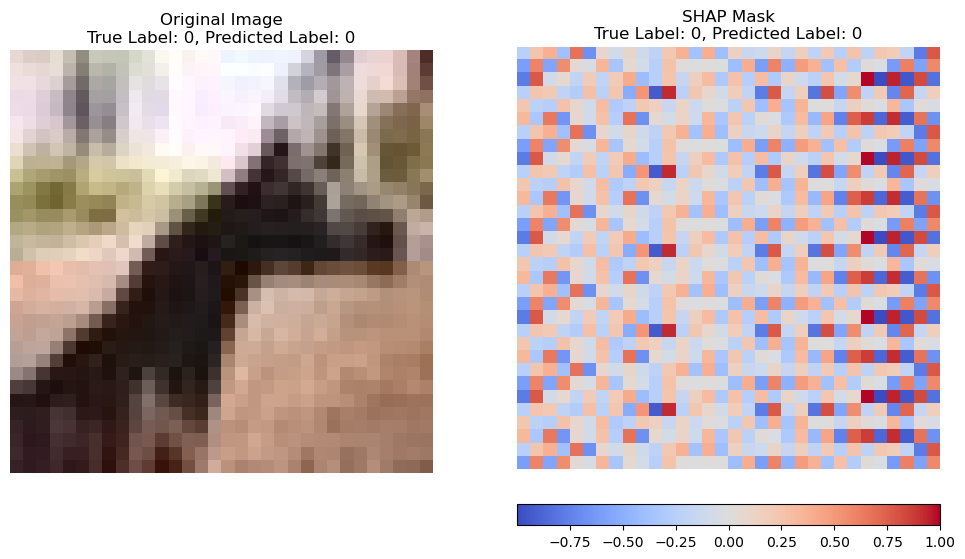

1/1 [==============================] - 0s 20ms/step


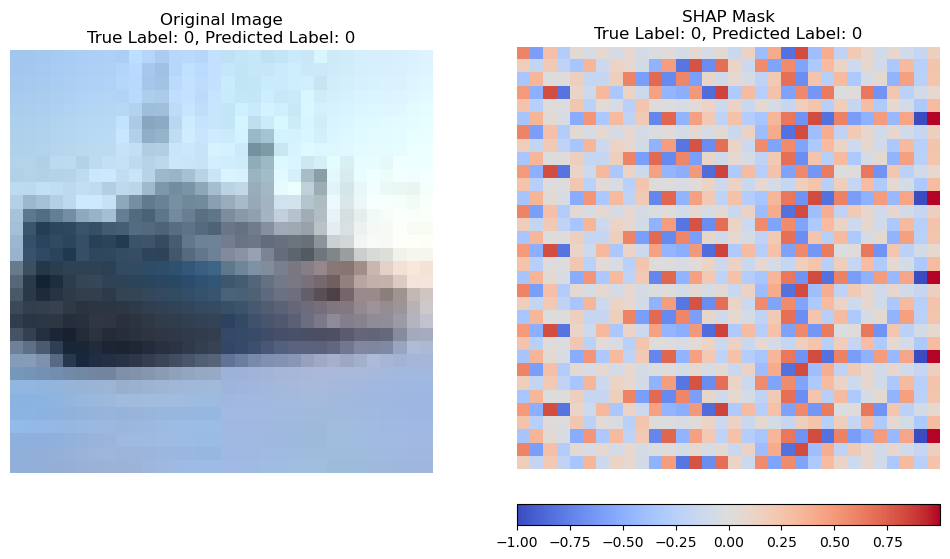

1/1 [==============================] - 0s 30ms/step


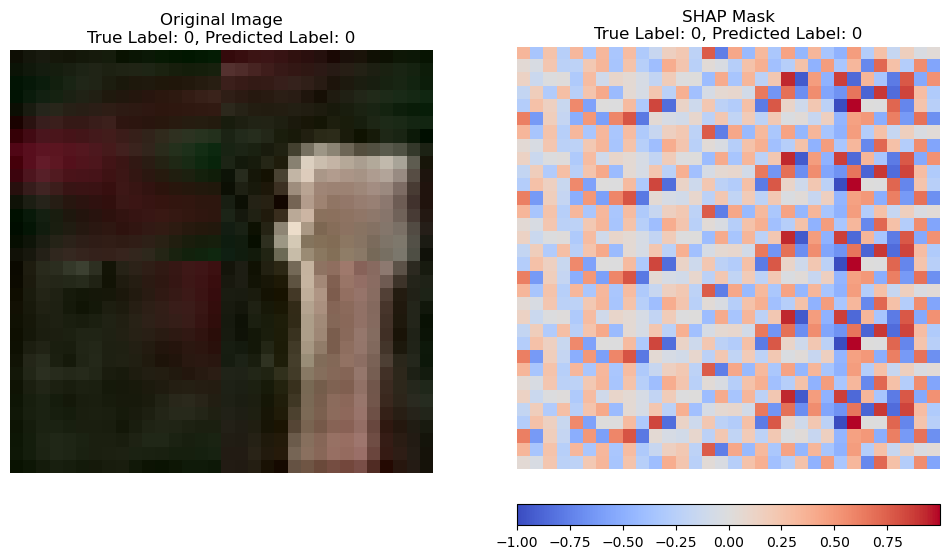

1/1 [==============================] - 0s 24ms/step


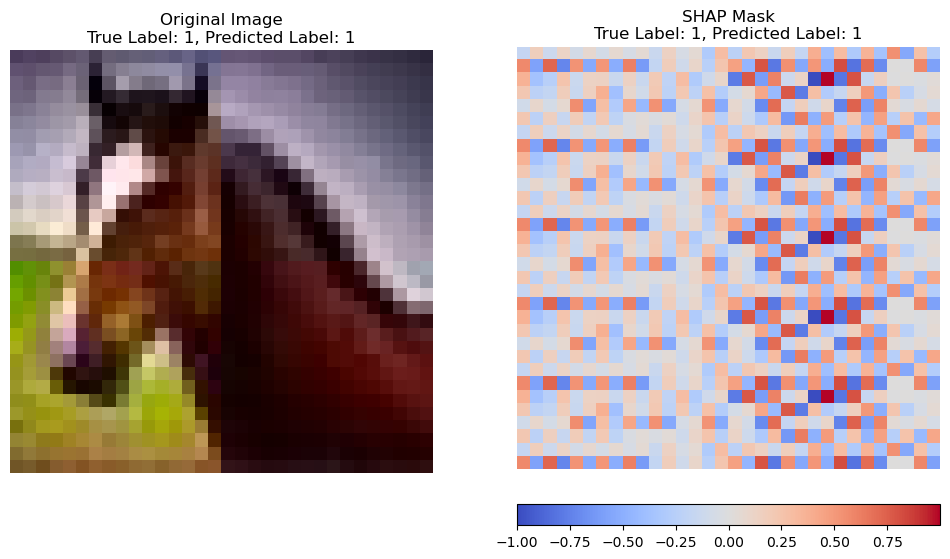

1/1 [==============================] - 0s 25ms/step


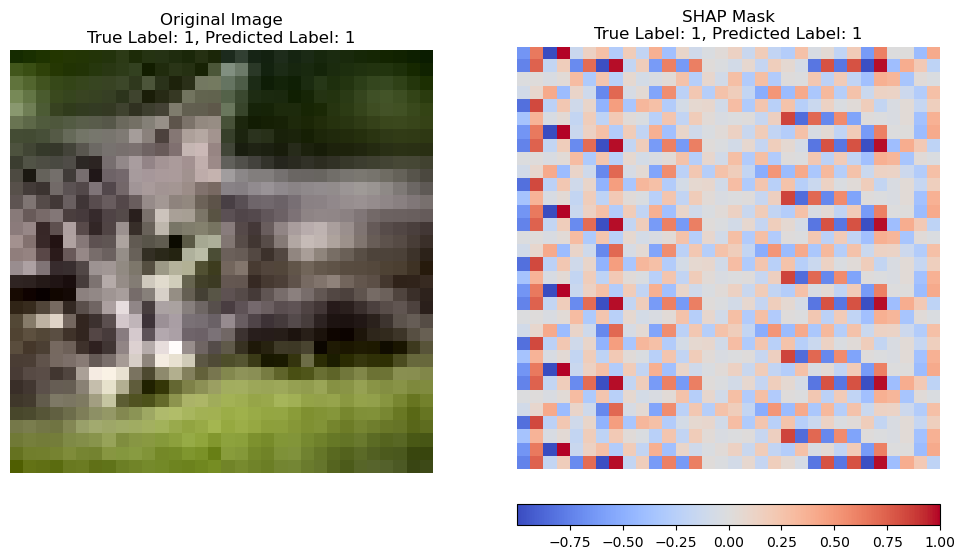

1/1 [==============================] - 0s 38ms/step


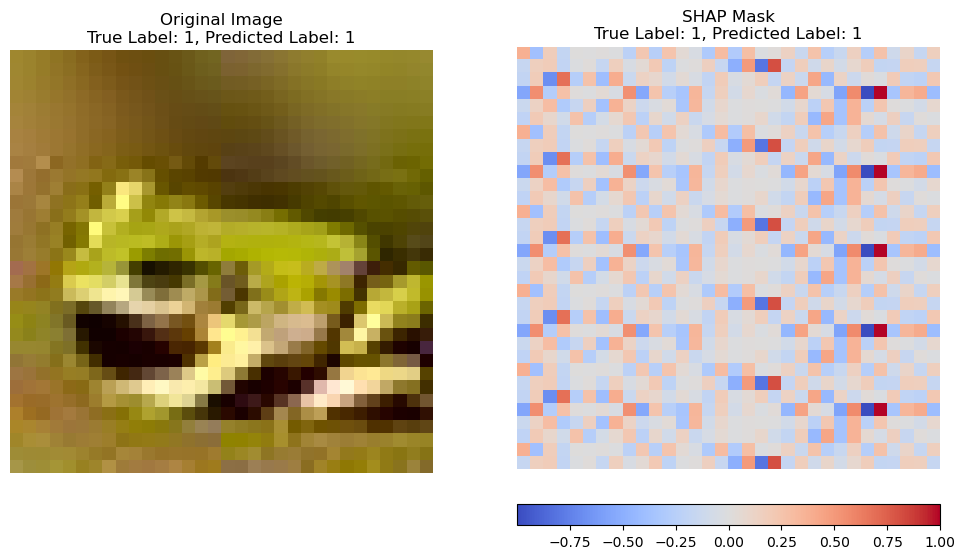

1/1 [==============================] - 0s 30ms/step


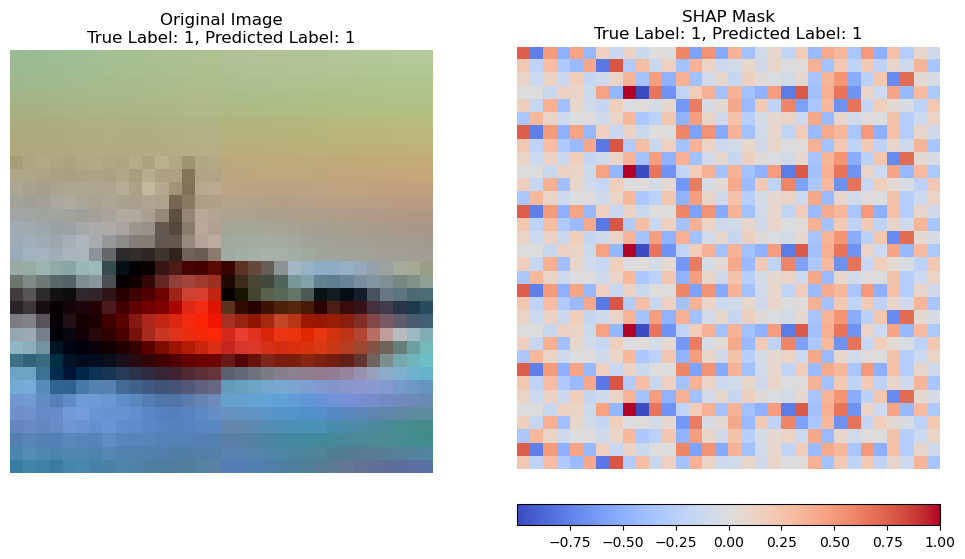

1/1 [==============================] - 0s 26ms/step


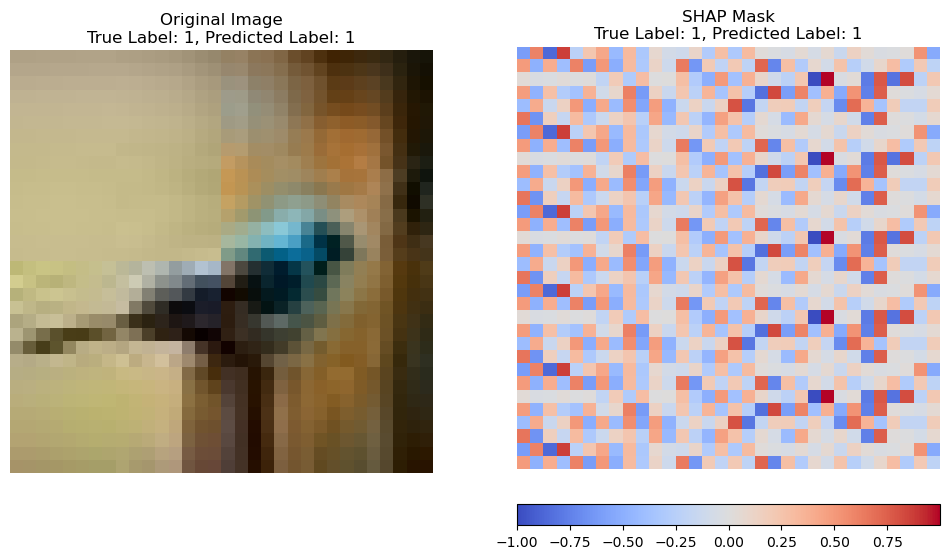

1/1 [==============================] - 0s 29ms/step


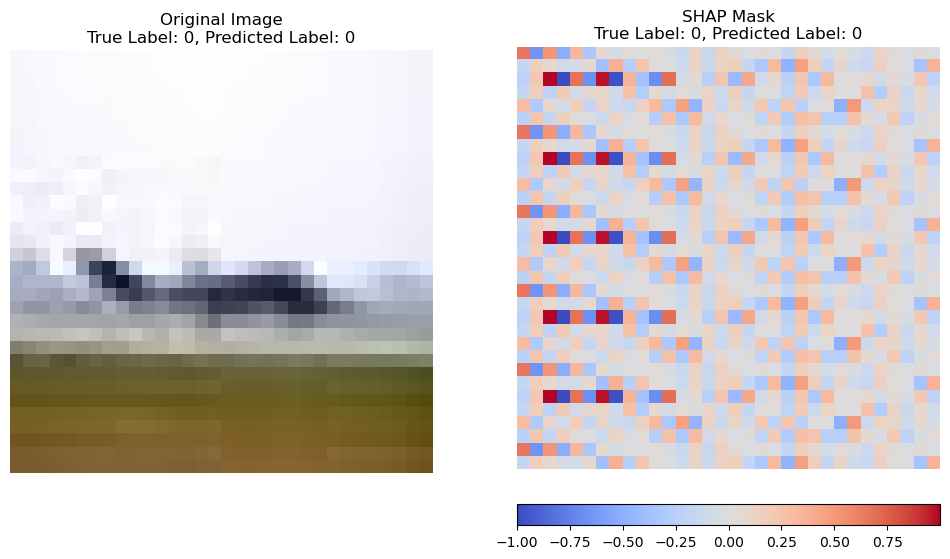

1/1 [==============================] - 0s 30ms/step


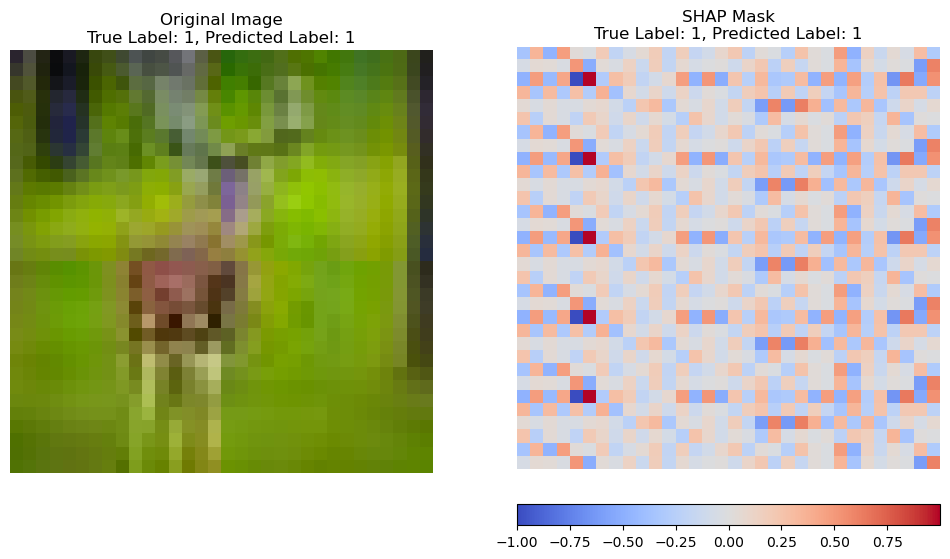

1/1 [==============================] - 0s 40ms/step


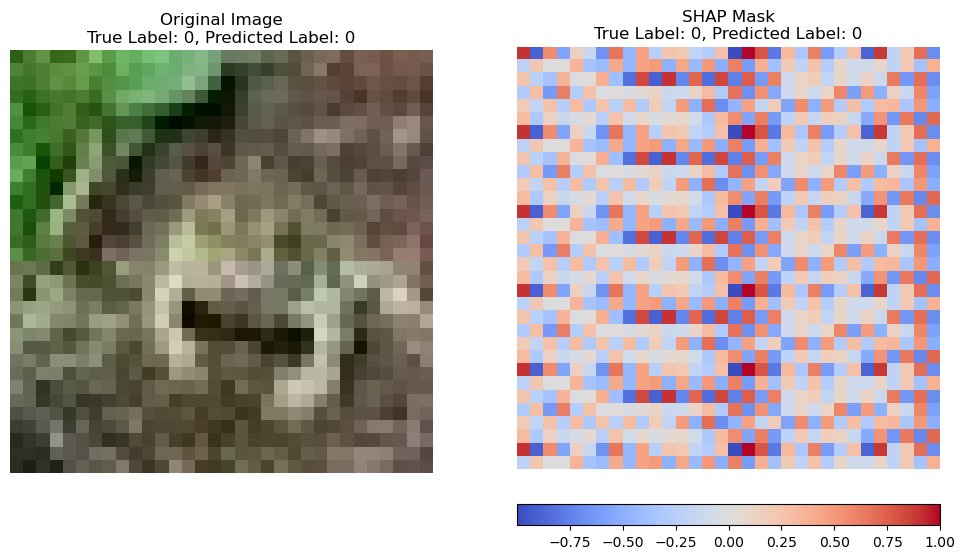

1/1 [==============================] - 0s 28ms/step


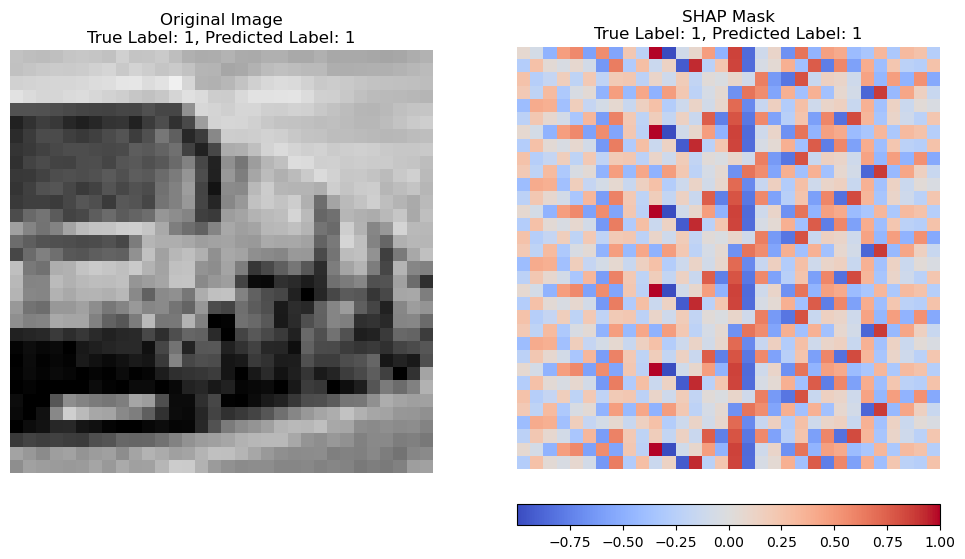

1/1 [==============================] - 0s 23ms/step


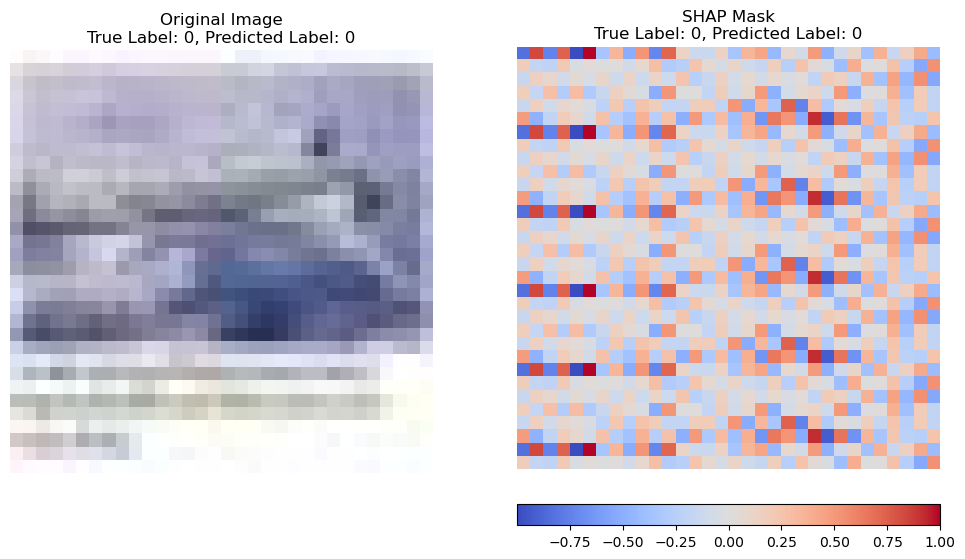

1/1 [==============================] - 0s 41ms/step


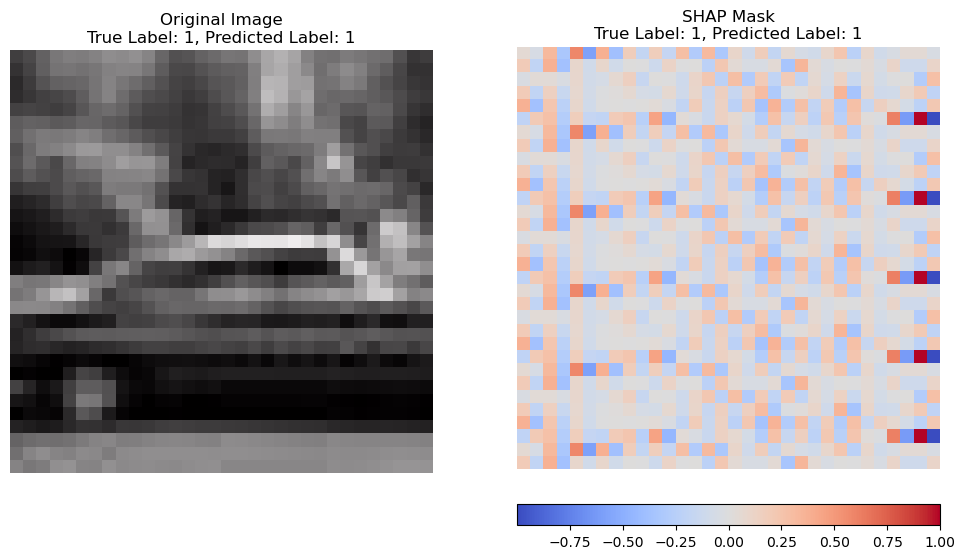

1/1 [==============================] - 0s 47ms/step


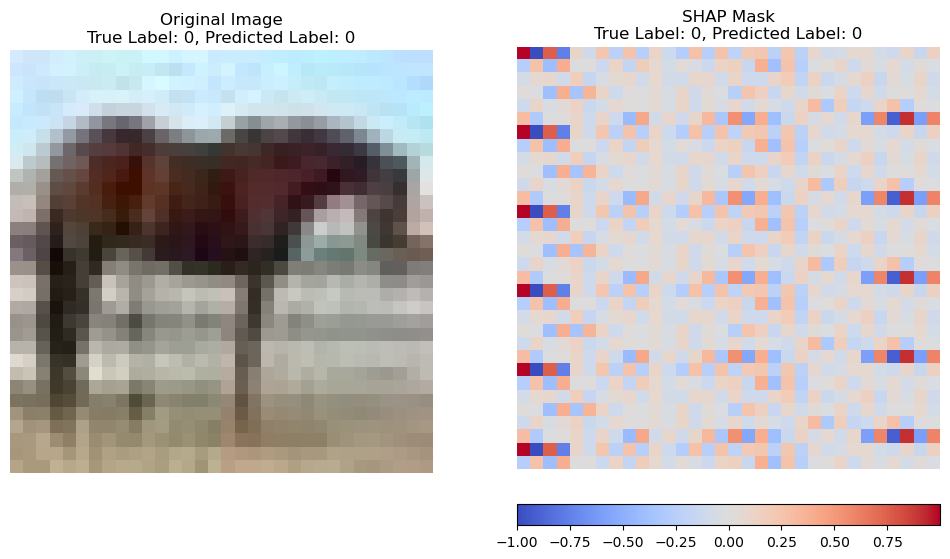

1/1 [==============================] - 0s 30ms/step


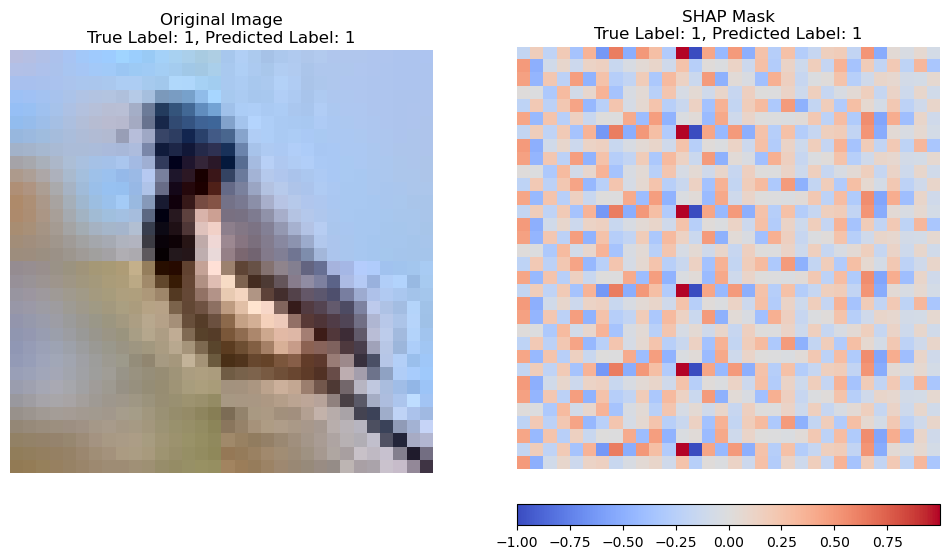

1/1 [==============================] - 0s 45ms/step


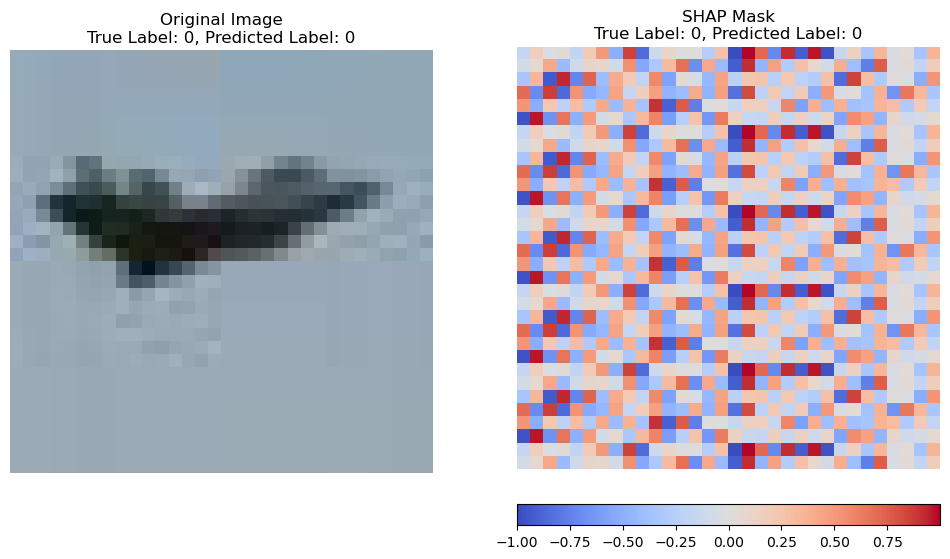

1/1 [==============================] - 0s 26ms/step


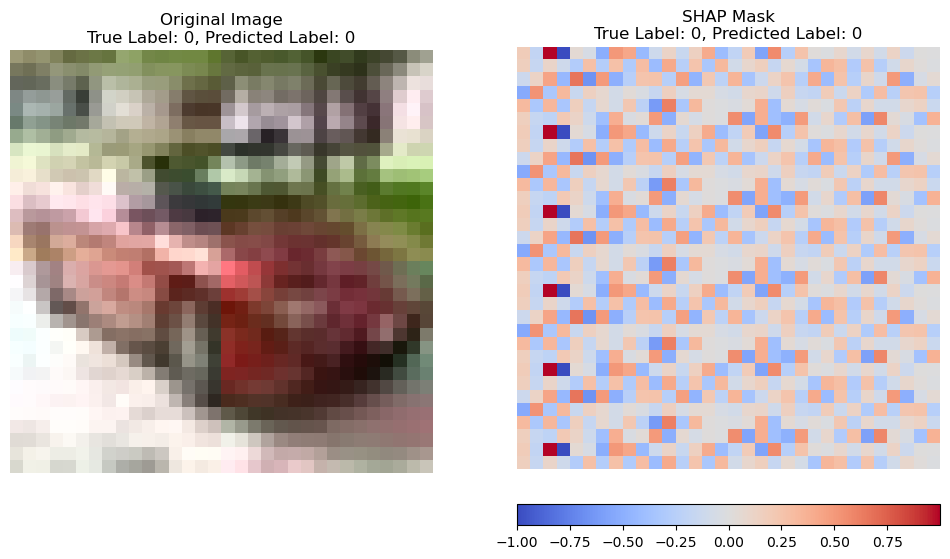

1/1 [==============================] - 0s 30ms/step


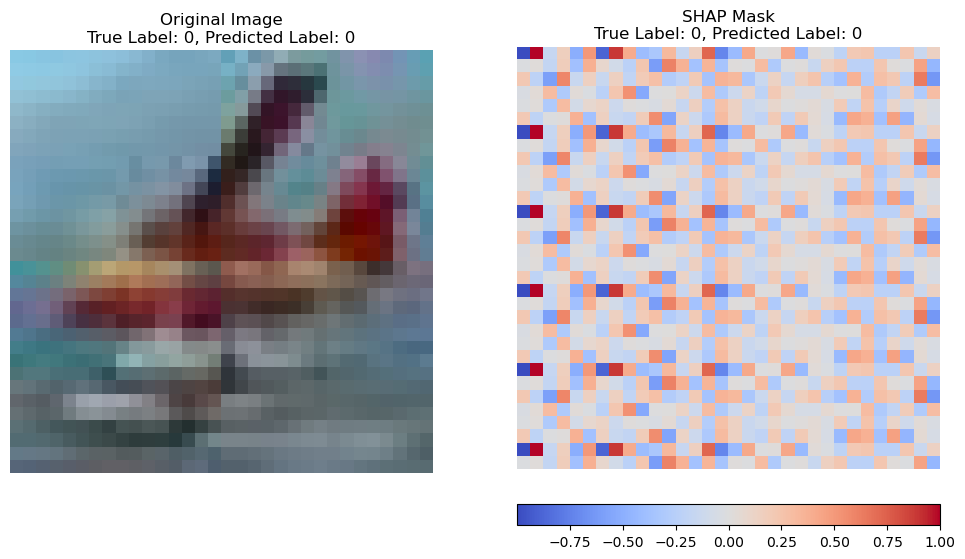

1/1 [==============================] - 0s 49ms/step


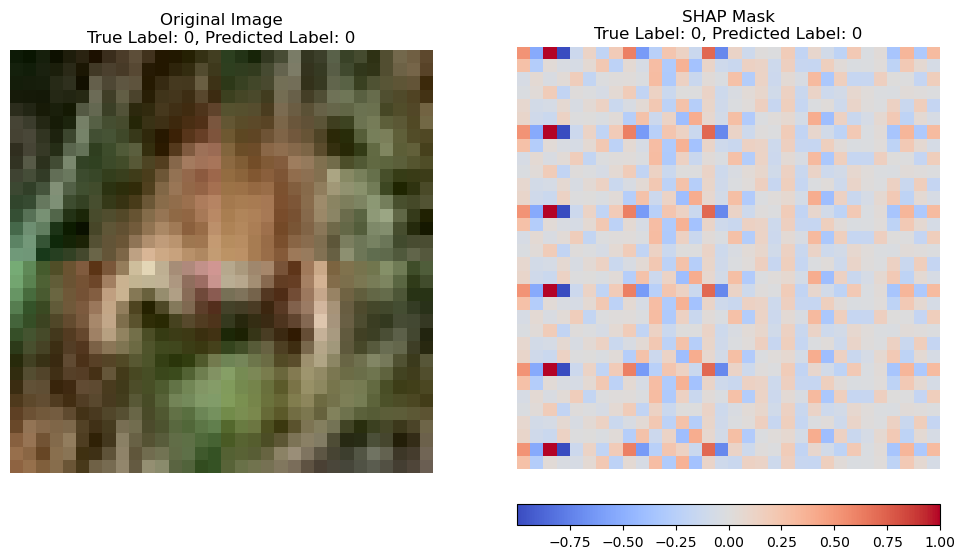

IndexError: index 32 is out of bounds for axis 0 with size 32

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf

# Load the best saved model
best_model = tf.keras.models.load_model('best_model.h5')

# Create a SHAP explainer
explainer = shap.GradientExplainer(best_model, X_train)

# Select a subset of the test data to explain
subset_size = 100  # Number of samples to explain
X_test_subset = X_test[:subset_size]
y_test_subset = y_test[:subset_size]

# Generate SHAP values
shap_values = explainer.shap_values(X_test_subset)

for i in range(subset_size):
    # Combine the SHAP values across the channels correctly
    combined_shap_values = np.sum(shap_values, axis=0)[i]

    # Normalize SHAP values for better visualization
    max_abs_shap = np.max(np.abs(combined_shap_values))
    if max_abs_shap > 0:
        combined_shap_values = combined_shap_values / max_abs_shap

    # Ensure SHAP values match the original image dimensions
    if combined_shap_values.shape != X_test_subset[i].shape[:2]:
        combined_shap_values = np.resize(combined_shap_values, X_test_subset[i].shape[:2])

    # Get the true and predicted labels
    true_label = np.argmax(y_test_subset[i])
    predicted_label = np.argmax(best_model.predict(np.expand_dims(X_test_subset[i], axis=0)))

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 9))

    # Subplot 1: Original Image
    ax[0].imshow(X_test_subset[i])
    ax[0].set_title(f"Original Image\nTrue Label: {true_label}, Predicted Label: {predicted_label}")
    ax[0].axis('off')

    # Subplot 2: SHAP Mask (SHAP values as a heatmap)
    mask = ax[1].imshow(combined_shap_values, cmap='coolwarm')
    cbar = fig.colorbar(mask, ax=ax[1], orientation='horizontal', pad=0.05)
    cbar.ax.tick_params(labelsize=10)
    ax[1].set_title(f"SHAP Mask\nTrue Label: {true_label}, Predicted Label: {predicted_label}")
    ax[1].axis('off')

    plt.show()


In [13]:
import platform
import psutil

# Print basic CPU info
print("Processor:", platform.processor())

# Print number of cores
print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))

# Print CPU frequencies
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
print(f"Current Frequency: {cpufreq.current:.2f}Mhz")

# Print system RAM
print("Total memory:", psutil.virtual_memory().total / (1024 ** 3), "GB")



Processor: AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
Physical cores: 8
Total cores: 16
Max Frequency: 2701.00Mhz
Min Frequency: 0.00Mhz
Current Frequency: 2155.00Mhz
Total memory: 11.769847869873047 GB


Stack Overflow. (2016). How to load images from a directory on the computer in Python. [online] Available at: https://stackoverflow.com/questions/36774431/how-to-load-images-from-a-directory-on-the-computer-in-python [Accessed 30 Sept. 2024].
NumPy: Harris, C.R., Millman, K.J., van der Walt, S.J., et al. (2020). Array programming with NumPy. Nature, 585, 357–362. https://numpy.org/doc/stable/
PIL (Pillow): Clark, A. (2015). Pillow: Python Imaging Library (Fork). https://python-pillow.org/
Chollet, F. (2015). Keras. https://keras.io
TensorFlow Developers. (2015). TensorFlow: Large-scale machine learning on heterogeneous systems. https://www.tensorflow.org/
TensorFlow. (n.d.). Convolutional Neural Network (CNN) Tutorial. [online] Available at: https://www.tensorflow.org/tutorials/images/cnn#:~:text=This%20tutorial%20demonstrates%20training%20a#:~:text=This%20tutorial%20demonstrates%20training%20a.
YouTube. (2020). Interpretable Machine Learning with SHAP (SHapley Additive exPlanations). [online video] Available at: https://www.youtube.com/watch?v=Re4HCqaQIyY&t=151s.





Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
